In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

import add_path
from toolkit.pipeline.global_settings import GLOBAL_SETTINGS
from toolkit.pipeline.data_io import get_existing_sessions, get_session_selection, SessionDirectory
from toolkit.analysis.statistics import quantize_nd, statistic_in_grid, range_by_iqr, LRA, WLRA
from toolkit.plots.plots import heatmap_in_grid
from toolkit.plots.colors import BAND_COLORS
from toolkit.plots.format import format_text, SAVE_FIGURE, save_figure

## Config

In [2]:
config_name = 'mixed_stimuli_all_units_all_layers_2-100Hz'

In [3]:
session_set = 'selected'  # 'all', 'selected', 'test'

ecephys_structure_acronym = GLOBAL_SETTINGS['ecephys_structure_acronym']

# get existing sessions in the data cache directory
session_list, missing_sessions = get_existing_sessions(session_set, structure_acronym=ecephys_structure_acronym)

sessions_df = get_session_selection().loc[session_list]
session_list = sessions_df.index[sessions_df['has_lfp_data']].tolist()

## Get heatmap data from session

In [4]:
power_dss = {}
n_units = {}

for session_id in session_list:
    session_dir = SessionDirectory(session_id, ecephys_structure_acronym)

    if not session_dir.exist:
        print(f"Failed to load session {session_id}: session directory does not exist")
    elif not session_dir.has_lfp_data: # skip if no lfp data
        print(f"Skip loading session {session_id}: no lfp data")
    else:
        session_parameters = session_dir.load_population_vector_parameters(config_name=config_name)
        n_units[session_id] = session_parameters['n_units']
        if 'n_main_pc' in session_parameters:
            power_dss[session_id] = session_dir.load_population_vector_data(config_name=config_name)
        else:
            print(f"Session {session_id} does not have enough units ({n_units[session_id]}) for PCA analysis.")

print("Variable names: ", power_dss[session_id].variable_name.values)
combine_stimulus_name = power_dss[session_id].attrs['stimulus']

n_units = pd.Series(n_units)

Variable names:  ['mean_fr' 'rms_fr' 'length' 'speed' 'angle' 'radial' 'tangent']


## Plot heatmaps

In [5]:
x_var = 'radial'
y_var = 'tangent'

temperature = 1  # for softmax normalization on power (lower temperature, more weight on high power)
rank = 1  # rank of low-rank approximation

weighted = True  # average power across sessions weighted by count proportion
n_iqr = [1.5, 1.5]  # value range limited by outlier in term of multiple of interquartile
# n_iqr = np.inf  # no value range limit

n_bins = 10
figsize = (8, 3.6)

signed_var = {'radial'}

In [6]:
heatmap_ds = {}
bin_edges = {}
for session_id, power_ds in power_dss.items():
    # get quantile grids and average power in grids
    power = power_ds.power.transpose('wave_band', 'sample').values
    idx_in_grid, (x_bins, y_bins), hist_count = quantize_nd([power_ds[x_var], power_ds[y_var]], n_bins=n_bins)
    power_avg, hist_count = statistic_in_grid(power, idx_in_grid, hist_counts=hist_count)

    # power follows exponential distribution (Boltzmann distribution)
    # increase importance by taking exponential like softmax normalization
    power_std = np.std(power, axis=1)
    power_softmax = statistic_in_grid(np.exp(power / power_std[:, None] / temperature),
        idx_in_grid, hist_counts=hist_count)[0]

    heatmap_ds[session_id] = xr.Dataset(
        data_vars=dict(
            power=(('wave_band', 'x_bin', 'y_bin'), power_avg),
            power_softmax=(('wave_band', 'x_bin', 'y_bin'), power_softmax),
            hist_count=(('x_bin', 'y_bin'), hist_count),
        ),
        coords=dict(
            wave_band=power_ds.coords['wave_band'],
            x_bin=range(x_bins.size - 1), y_bin=range(y_bins.size - 1)
        )
    )
    bin_edges[session_id] = xr.Dataset(
        data_vars=dict(
            x_edges=('x_bin', x_bins),
            y_edges=('y_bin', y_bins)
        ),
        coords=dict(x_bin=np.linspace(0, 1, x_bins.size), y_bin=np.linspace(0, 1, y_bins.size))
    )
heatmap_ds = xr.concat(heatmap_ds.values(), dim=pd.Index(heatmap_ds, name='session'))
bin_edges = xr.concat(bin_edges.values(), dim=pd.Index(bin_edges, name='session'))

sessions = heatmap_ds.coords['session'].values
wave_bands = power_ds.coords['wave_band'].values
xlabel, ylabel = power_ds.label.sel(variable_name=[x_var, y_var]).values
xticks_fmt, yticks_fmt = power_ds.fmt.sel(variable_name=[x_var, y_var]).values
n_bins = np.array((heatmap_ds.x_bin.size, heatmap_ds.y_bin.size))

### low-rank approximation

In [7]:
center_shape = (sessions.size, wave_bands.size, 2)
center_ds = xr.Dataset(
    data_vars=dict(
        power_lra=heatmap_ds.power.copy(),
        lra_center=(('session', 'wave_band', 'axes'), np.empty(center_shape)),
        mass_center=(('session', 'wave_band', 'axes'), np.empty(center_shape)),
        pc_axes=(('session', 'wave_band', 'pc', 'axes'), np.empty(center_shape + (2, ))),
    ),
    coords=dict(
        session=heatmap_ds.coords['session'],
        wave_band=heatmap_ds.coords['wave_band'],
        axes=['x', 'y'],
        pc=np.arange(2)
    )
)
center_weighted_ds = center_ds.copy(deep=True)
peak_ds = xr.Dataset(dict(
    power_peak=center_ds.lra_center.copy(),
    softmax_peak=center_ds.lra_center.copy(),
))

In [8]:
bins = np.array(list(np.ndindex(*n_bins)))
bins_idx = tuple(bins.T)
bin_centers = (bins + 0.5) / n_bins

for i, session_id in enumerate(sessions):
    for w, wave_band in enumerate(wave_bands):
        hm_ds = heatmap_ds.sel(session=session_id, wave_band=wave_band)
        hist_count = hm_ds.hist_count.values[tuple(bins.T)]
        idx = hist_count > 0

        pk_ds = peak_ds.sel(session=session_id, wave_band=wave_band)
        pk_ds.power_peak[:] = bin_centers[np.nanargmax(hm_ds.power)]
        pk_ds.softmax_peak[:] = bin_centers[np.nanargmax(hm_ds.power_softmax)]

        # power_weights = hm_ds.power.values[tuple(bins.T)]
        power_weights = hm_ds.power_softmax.values[tuple(bins.T)]

        # weighted by power only
        ds = center_ds.sel(session=session_id, wave_band=wave_band)
        ds.mass_center[:] = np.average(bin_centers[idx], weights=power_weights[idx], axis=0)
        C = np.cov(bin_centers[idx].T, aweights=power_weights[idx])
        eigvals, eigvecs = np.linalg.eigh(C)
        ds.pc_axes[:] = (eigvecs * np.sqrt(eigvals)).T
        ds.power_lra[:] = LRA(hm_ds.power, rank=rank)
        ds.lra_center[:] = bin_centers[np.nanargmax(ds.power_lra)]

        # weighted by power and count
        ds = center_weighted_ds.sel(session=session_id, wave_band=wave_band)
        ds.mass_center[:] = np.average(bin_centers[idx], weights=power_weights[idx] * hist_count[idx], axis=0)
        C = np.cov(bin_centers[idx].T, fweights=hist_count[idx], aweights=power_weights[idx])
        eigvals, eigvecs = np.linalg.eigh(C)
        ds.pc_axes[:] = (eigvecs * np.sqrt(eigvals)).T
        ds.power_lra[:] = WLRA(hm_ds.power, weights=hm_ds.hist_count, rank=rank)
        ds.lra_center[:] = bin_centers[np.nanargmax(ds.power_lra)]

### Compile data from all sessions

In [9]:
if weighted:
    # average power weighted by count proportion of each bin in each session
    weights = heatmap_ds.hist_count.transpose('session', 'x_bin', 'y_bin')
    weights = weights / weights.sum(dim=['x_bin', 'y_bin'])  # proportion of bin in each session
    weights.values[:, ~weights.all(dim='session').values] = 1.0  # equal weights for bins with no count in all sessions
    avg_pow = heatmap_ds.power.weighted(weights).mean(dim='session') # weighted average
else:
    # unweighted average power
    avg_pow = heatmap_ds.power.mean(dim='session')  # average

In [10]:
# Annotation kwargs for average zero location
avg_zero_annot_kwargs = dict(
    x = dict(
        xy = [0, 0], xytext = (1, -0.08),
        ha = 'right', va = 'top', rotation = 0
    ),
    y = dict(
        xy = [0, 0], xytext = (-0.08, 0),
        ha = 'right', va = 'bottom', rotation = 90
    )
)

# Get average location of zero value of signed variable
for ax, v in zip('xy', [x_var, y_var]):
    if v in signed_var:
        edges = bin_edges[ax + '_edges']
        bins_coord = bin_edges.coords[ax + '_bin'].values
        avg_zero_bin = np.mean([np.interp(0, edges.sel(session=i), bins_coord) \
            for i in bin_edges.coords['session'].values])
        avg_zero_annot_kwargs[ax]['xy']['xy'.index(ax)] = avg_zero_bin
    else:
        avg_zero_annot_kwargs[ax] = None

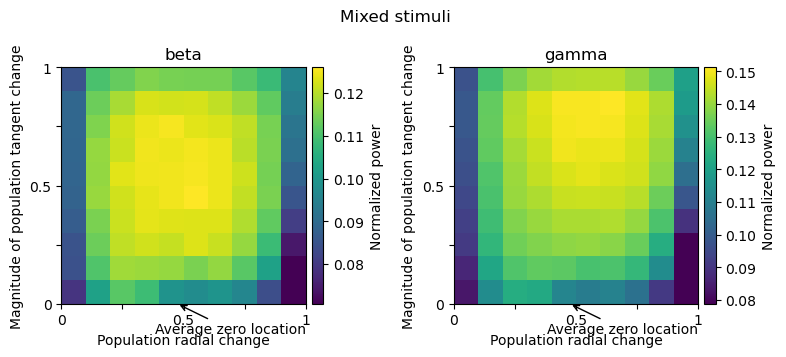

In [11]:
nticks = 5  # number of ticks on the axes
tick_locator = plt.LinearLocator(numticks=nticks)

x_bins, y_bins = bin_edges.coords['x_bin'].values, bin_edges.coords['y_bin'].values

fig1, axs = plt.subplots(1, 2, figsize=figsize)
for ax, w in zip(axs, wave_bands):
    C = avg_pow.sel(wave_band=w).values
    vmin, vmax = range_by_iqr(C, n_iqr=n_iqr)
    pcm, _ = heatmap_in_grid(C, x_bins, y_bins, vmin=vmin, vmax=vmax,
        xticks_fmt='{:g}', yticks_fmt='{:g}', even_grid=False, ax=ax)
    plt.colorbar(mappable=pcm, ax=ax, label='Normalized power', pad=0.02)
    for kwargs in avg_zero_annot_kwargs.values():
        if kwargs is not None:
            ax.annotate(f'Average zero location', fontsize=10,
                arrowprops=dict(arrowstyle='->', color='k'), **kwargs)
    ax.get_xaxis().set_major_locator(tick_locator)
    ax.get_yaxis().set_major_locator(tick_locator)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(w)
fig1.suptitle(format_text(combine_stimulus_name))
fig1.tight_layout()
plt.show()

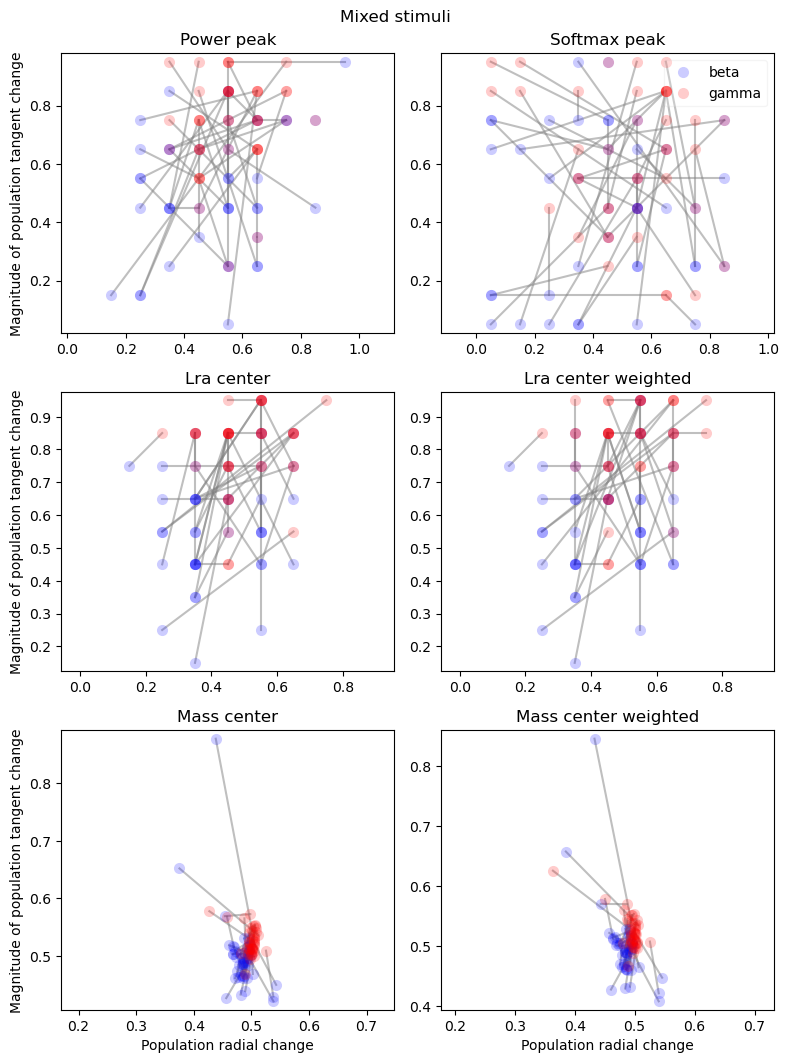

In [12]:
das = [
    peak_ds.power_peak, peak_ds.softmax_peak,
    center_ds.lra_center, center_weighted_ds.lra_center,
    center_ds.mass_center, center_weighted_ds.mass_center
]
labels = [format_text(da.name) for da in das]
labels[3] += ' weighted'
labels[5] += ' weighted'

fig2, axs = plt.subplots(len(das) // 2, 2, figsize=(figsize[0], len(das) // 2 * figsize[1]))
for i, da in enumerate(das):
    ax = axs.ravel()[i]
    da = da.transpose('axes', 'session', 'wave_band')
    for j in range(sessions.size):
        ax.plot(*da.isel(session=j).values, 'gray', alpha=0.5)
    for w in wave_bands:
        ax.plot(*da.sel(wave_band=w).values, label=w, markerfacecolor=BAND_COLORS[w],
            marker='o', markeredgecolor='none', linestyle='none', markersize=8, alpha=0.2)
    if i // 2 == axs.shape[0] - 1:
        ax.set_xlabel(xlabel)
    if i % 2 == 0:
        ax.set_ylabel(ylabel)
    ax.set_title(labels[i])
    ax.set_aspect('equal', adjustable='datalim')
axs[0, -1].legend(loc='upper right', framealpha=0.2)
fig2.suptitle(format_text(combine_stimulus_name))
fig2.tight_layout()
plt.show()

## Save figures

In [13]:
# Average power heatmap
if SAVE_FIGURE:
    from toolkit.paths.paths import FIGURE_DIR

    var_str = f"{y_var}-{x_var}"
    session_set_name = f'{session_set}_sessions'

    config_dir = FIGURE_DIR / "population_vector" / config_name
    config_dir.mkdir(parents=True, exist_ok=True)

    save_figure(config_dir, fig1, f"{var_str}_{session_set_name}")
    save_figure(config_dir, fig2, f"{var_str}_centers_{session_set_name}")

In [14]:
# Individual sessions power heatmap
if SAVE_FIGURE and session_set == 'all':  # save only when running for all sessions
    heatmap_dir = config_dir / var_str
    heatmap_dir.mkdir(parents=True, exist_ok=True)

    # Individual sessions power heatmap
    n_std = 1  # standard deviation of principal axes to visualize
    for session_id in heatmap_ds.coords['session'].values:
        x_bins = bin_edges.sel(session=session_id).x_edges
        y_bins = bin_edges.sel(session=session_id).y_edges
        dss = [center_ds.sel(session=session_id), center_weighted_ds.sel(session=session_id)]

        fig = plt.figure(figsize=(figsize[0], 3 * figsize[1]), constrained_layout=True)
        subfigs = fig.subfigures(3, 1)
        axs = [sf.subplots(1, 2) for sf in subfigs]
        for j, w in enumerate(wave_bands):
            ax = axs[0][j]
            pcm, _ = heatmap_in_grid(heatmap_ds.power.sel(session=session_id, wave_band=w).values,
                x_bins, y_bins, xticks_fmt=xticks_fmt, yticks_fmt=yticks_fmt, even_grid=True, ax=ax)
            plt.colorbar(mappable=pcm, ax=ax, label='Normalized power', pad=0.02)
            pk_ds = peak_ds.sel(session=session_id, wave_band=w)
            ax.plot(*pk_ds.power_peak, 'ro', label='Power peak', markersize=10, markerfacecolor='none', markeredgewidth=2)
            ax.plot(*pk_ds.softmax_peak, 'bo', label='Softmax peak', markersize=8, markerfacecolor='none', markeredgewidth=2)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            if j == wave_bands.size - 1:
                ax.legend(loc='upper right', framealpha=0.2)
            ax.set_title(w)

            for i, ds in enumerate(dss):
                ax = axs[i + 1][j]
                ds = ds.sel(wave_band=w)
                pcm, _ = heatmap_in_grid(ds.power_lra.values, x_bins, y_bins,
                    xticks_fmt=xticks_fmt, yticks_fmt=yticks_fmt, even_grid=True, ax=ax)
                plt.colorbar(mappable=pcm, ax=ax, label='Normalized power', pad=0.02)

                pc_axes = ds.mass_center.values[:, None] + n_std * np.array([-1, 1]) * ds.pc_axes.values[..., None]
                hd3 = ax.plot(*pc_axes[0], color='k', linewidth=2, alpha=0.5)[0]
                ax.plot(*pc_axes[1], color='k', linewidth=2, alpha=0.5)
                hd1 = ax.plot(*ds.lra_center, 'ro', markersize=10, markerfacecolor='none', markeredgewidth=2)[0]
                hd2 = ax.plot(*ds.mass_center, 'bo', markersize=8, markerfacecolor='none', markeredgewidth=2)[0]

                ax.set_xlabel(xlabel)
                if j == wave_bands.size - 1:
                    ax.legend([hd1, hd2, hd3], ['LRA peak', 'Mass center', 'Principal axes'],
                        loc='upper right', framealpha=0.2)
        fig.suptitle(f"Session {session_id:d}")
        subfigs[1].suptitle('LRA')
        subfigs[2].suptitle('LRA weighted by counts')

        save_figure(heatmap_dir, fig, f"session_{session_id}")
        plt.close(fig)